In [108]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from lifelines import KaplanMeierFitter

# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [5]:
df = sns.load_dataset("titanic")

df["class"] = df["class"].astype(str)
df["deck"] = df["deck"].astype(str)

df.age = df.age.fillna(0)
df["missing_age"] = (df.age == 0).astype(int)

In [8]:
x = df.copy()

x = x.join(pd.get_dummies(x["class"], drop_first = True))
x = x.join(pd.get_dummies(x["deck"], drop_first = True))
# x = x.join(pd.get_dummies(x["alone"], drop_first = True))
x = x.join(pd.get_dummies(x["embark_town"], drop_first = True))
x = x.join(pd.get_dummies(x["embarked"], drop_first = True))
x = x.join(pd.get_dummies(x["sex"], drop_first = True))
x = x.join(pd.get_dummies(x["who"], drop_first = True))
# x = x.join(pd.get_dummies(x["adult_male"], drop_first = True))
x["age2"] = x.age ** 2
x["age3"] = x.age ** 3
x["fare2"] = x.fare ** 2
x["fare3"] = x.fare ** 3
x["missing_age"] = df["missing_age"]

x = x.drop(columns = ["survived", "alive", "class", "deck", "alone", "embark_town", "embarked", "sex", "who", "adult_male"])

# model revisions
x = x.drop(columns = ["B", "C", "D", "E", "F", "G", "nan"]) # first revision
x = x.drop(columns = ["age", "missing_age", "Q", "S"]) # second revision
x = x.drop(columns = ["Queenstown", "Southampton"]) # third revision
x = x.drop(columns = ["male", "woman", "age2", "age3"]) # fourth revision: final revision for most statistically significant fit

y = df["survived"]
x = sm.add_constant(x)

In [14]:
est = sm.OLS(y, x).fit()
# display(est.summary())

# R-squared: 0.425
# AIC: 768.9
# BIC 812.0

In [15]:
est = sm.Logit(y, x).fit()
# display(est.summary())

# pseudo R-squared: 0.3708

Optimization terminated successfully.
         Current function value: 0.418966
         Iterations 19


In [ ]:
# The Logit fit seems worse but not by a significantly large margin.

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [114]:
# Got help from Jasleen

In [19]:
temp = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [59]:
temp

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [79]:
X = temp[0]
y = temp[1]
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# X_std = pd.DataFrame(X_std)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=0)

In [94]:
logreg = LogisticRegression(solver = "lbfgs", max_iter = 1000)
l_result = logreg.fit(X_train, y_train)

In [107]:
l_result

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [39]:
fish = pd.read_csv("data/fish.csv")
fish.head()

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
0,0,0,1,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1


In [40]:
X = fish.drop(columns = ["FISH_COUNT"])
y = fish.FISH_COUNT

In [41]:
est = sm.ZeroInflatedPoisson(y, sm.add_constant(X)).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


C:\Users\rando\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Sat, 30 Jan 2021   Pseudo R-squ.:                  0.3471
Time:                         14:00:30   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.278     -9.099      0.000      -3.078      -1.987
LIVE_BAIT         1.7086      0.242      7.073      0.000       1.235       2.182
CAMPER            0.6745      0.094      7.191      0.000       0.491       0.858
PERSONS           0.8752      0.043     20.447      0.000       0.791       0.959
CHILDREN         -1.3957      0.090    -15.582      0.000      -1.571      -1.220
=================================================================================
"""

## Results of Counting Poissons

### All features are statistically significant

#### LIVE_BAIT: The coefficient and standard deviation are much higher than the other features. As one would expect, using live bait when fishing gets better results
#### CAMPER: The coefficient is positive, though the weakest of the positive features. It's standard error is also the highest, which make it seem a little less reliable than the other features.
#### PERSONS: Here we can see that for each extra person in fishing group, there's an 87.5% chance increase in the capture of a fish. More hooks = more temptations.
#### CHILDREN: Really no surprise here, the coefficient is the lowest, and pretty far low at that. The standard error is also very high. Moral is don't bring kids fishing.

# 4. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**4.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**4.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [43]:
df = pd.read_csv("data/telco_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [48]:
df.Churn = (df.Churn == "Yes").astype(int)

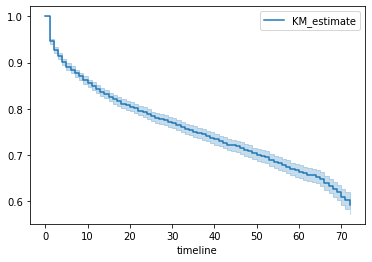

In [51]:
T = df['tenure']
E = df['Churn']
kmf = KaplanMeierFitter()
kmf.fit(T, E)
kmf.plot_survival_function();

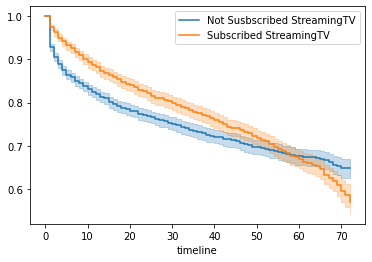

In [56]:
groups = df['StreamingTV']
ix = (groups == 'Yes')
kmf.fit(T[~ix], E[~ix], label='Not Susbscribed StreamingTV')
ax = kmf.plot_survival_function()
kmf.fit(T[ix], E[ix], label='Subscribed StreamingTV')
ax = kmf.plot_survival_function(ax=ax)